<a href="https://colab.research.google.com/github/hayatrajani/lidar-cnn/blob/main/LiDAR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = '/content/gdrive/My Drive/'

Mounted at /content/gdrive


#Import Modules

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import Sampler
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report, cohen_kappa_score
from collections import Counter, OrderedDict, defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import os
import copy
import csv

#Preprocess Data

##Fetch the Dataset

In [3]:
!unzip -q "$root_dir""lidar_dataset.zip"
data_dir = '/content/dataset/'

##Compute Mean and Standard Deviation for Normalization

In [4]:
def computeDatasetStats(loader):
    mean, std  = 0, 0
    samples = 0.
    for images, _ in loader:
        mean += torch.mean(images, dim=(0,2,3))
        std += torch.std(images, dim=(0,2,3))
        samples += 1
    return mean/samples, std/samples

data_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])
train_data = datasets.ImageFolder(os.path.join(data_dir,'train'), data_transforms)
train_dataloader = DataLoader(train_data, batch_size=1024, num_workers=1)

mean, std = computeDatasetStats(train_dataloader)

##Define and Apply Transformations

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ]),
}

data = {x: datasets.ImageFolder(os.path.join(data_dir,x), data_transforms[x])
            for x in ['train','test']}

data_sizes = {x: len(data[x]) for x in ['train','test']}

class_names = data['train'].classes
num_classes = len(class_names)

##Split Data into Training and Validation Sets

In [6]:
train_data_len = int(0.8*data_sizes['train'])
val_data_len = data_sizes['train']-train_data_len
data['train'], data['val'] = random_split(data['train'],(train_data_len,val_data_len))
data_sizes['train'] = train_data_len
data_sizes['val'] = val_data_len

##Sample and Load the Datasets

In [7]:
class ImbalancedDatasetSampler(Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    Adapted From:
        https://github.com/ufoym/imbalanced-dataset-sampler
    """

    def __init__(self, dataset, indices=None, num_samples=None):
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)
    
    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is datasets.ImageFolder:
            return dataset.imgs[idx][1]
        elif dataset_type is Subset:
            return dataset[idx][1]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
                    self.weights, self.num_samples, replacement=True))
        
    def __len__(self):
        return self.num_samples


samples = {x: max(Counter((lbl for _,lbl in data[x])).values())*num_classes
                for x in ['train','val']}
samples['test'] = max(Counter((data['test'].targets)).values())*num_classes
samplers = {x: ImbalancedDatasetSampler(data[x], num_samples=samples[x])
                for x in ['train','val','test']}
dataloaders = {x: DataLoader(data[x], batch_size=128, num_workers=1, sampler=samplers[x])
                for x in ['train','val','test']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Or Fetch and Preprocess Test Data (to Evaluate Pretrained Models)

In [ ]:
!unzip -q "$root_dir""lidar_test_dataset.zip"
test_data_dir = '/content/test_dataset/'

data_transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ])
test_data = datasets.ImageFolder(test_data_dir, data_transforms)
class_names = test_data.classes

test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

#Define the Network Architecture

In [9]:
class LiNet(nn.Module):
    def __init__(self):
        super(LiNet, self).__init__()
        self.features = nn.Sequential(OrderedDict([
                            ('conv0', nn.Conv2d(1,6,9)),
                            ('relu0', nn.ReLU()),
                            ('pool0', nn.AvgPool2d(2)),
                            ('bn0', nn.BatchNorm2d(6)),
                            ('conv1', nn.Conv2d(6,12,9)),
                            ('relu1', nn.ReLU()),
                            ('pool1', nn.AvgPool2d(2)),
                            ('bn1', nn.BatchNorm2d(12))
                        ]))
        self.classifier = nn.Sequential(OrderedDict([
                            ('fc0', nn.Linear(19*19*12,100)),
                            ('relu', nn.ReLU()),
                            ('bn', nn.BatchNorm1d(100)),
                            ('fc1', nn.Linear(100,3)),
                            ('softmax', nn.Softmax(dim=1)),
                            ('fc2', nn.Linear(3,3))
                        ]))
    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0),-1)
        out = self.classifier(out)
        return out

net = LiNet()

##And (optionally) load a pretrained model

In [ ]:
state_dict = torch.load(root_dir+'LiNet-adam_lr1e4_decay1e6.pth')
net.load_state_dict(state_dict)
net.eval()

#Train and Validate

Saving checkpoints in: /content/gdrive/My Drive/checkpoints/LiNet/
Logging to: /content/gdrive/My Drive/logs/LiNet/LiNet-fc3_adam_lr1e4_decay1e6-log.txt

Epoch 1/25
----------
Train Loss: 0.9984 Acc: 0.6357
Val Loss: 0.9360 Acc: 0.6501

Epoch 2/25
----------
Train Loss: 0.8699 Acc: 0.6517
Val Loss: 0.8262 Acc: 0.6474

Epoch 3/25
----------
Train Loss: 0.7524 Acc: 0.6579
Val Loss: 0.7308 Acc: 0.6541

Epoch 4/25
----------
Train Loss: 0.6535 Acc: 0.9356
Val Loss: 0.6484 Acc: 0.9223

Epoch 5/25
----------
Train Loss: 0.5682 Acc: 0.9874
Val Loss: 0.5931 Acc: 0.9163

Epoch 6/25
----------
Train Loss: 0.4973 Acc: 0.9895
Val Loss: 0.5237 Acc: 0.9359

Epoch 7/25
----------
Train Loss: 0.4349 Acc: 0.9909
Val Loss: 0.4858 Acc: 0.9311

Epoch 8/25
----------
Train Loss: 0.4014 Acc: 0.9931
Val Loss: 0.4799 Acc: 0.9272

Epoch 9/25
----------
Train Loss: 0.3945 Acc: 0.9939
Val Loss: 0.4741 Acc: 0.9277

Epoch 10/25
----------
Train Loss: 0.3887 Acc: 0.9940
Val Loss: 0.4727 Acc: 0.9263

Epoch 11/25
---

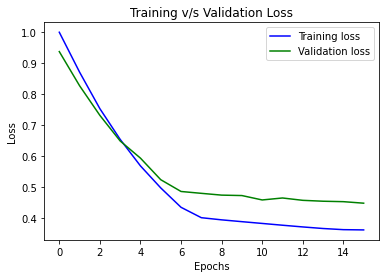

In [10]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']


def plot_loss(loss_history, epochs):
    plt.plot(range(epochs), loss_history['train'], 'b', label='Training loss')
    plt.plot(range(epochs), loss_history['val'], 'g', label='Validation loss')
    plt.title('Training v/s Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def train_model(model, criterion, optimizer, scheduler, epochs=25, 
                logging=False, checkpointing=False, resume_from_checkpoint=None):
    since = time.time()

    start = 0
    loss_history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = np.Inf
    epochs_no_improve = 0

    if resume_from_checkpoint:
        try:
            start, loss_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = root_dir+'checkpoints/LiNet/'
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = root_dir+'logs/LiNet/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'LiNet-adam_lr1e4_decay1e6-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)

    for epoch in range(start, epochs):
        print('\nEpoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)
        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_images = 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                num_images += inputs.size(0)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            #epoch_loss = running_loss / data_sizes[phase]
            #epoch_acc = running_corrects.double() / data_sizes[phase]
            
            # sampling changes dataset size
            epoch_loss = running_loss / num_images
            epoch_acc = running_corrects.double() / num_images
            
            loss_history[phase].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc))
            if logging:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase.capitalize(), epoch_loss, epoch_acc),file=log_file)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
                min_loss = epoch_loss
            elif phase == 'val' and epoch_acc <= best_acc:
                epochs_no_improve += 1
                if epochs_no_improve == 5:
                    time_elapsed = time.time() - since
                    print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                            time_elapsed // 60, time_elapsed % 60))
                    print('Best val Acc: {:4f}\n'.format(best_acc))
                    if logging:
                        print('\nEarly stopping! Completed in {:.0f}m {:.0f}s'.format(
                                time_elapsed // 60, time_elapsed % 60), file=log_file)
                        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
                    model.load_state_dict(best_model_wts)
                    return model, (loss_history, epoch+1)
        
        #save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'LiNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, loss_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'LiNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

    time_elapsed = time.time() - since
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))
    if logging:
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60), file=log_file)
        print('Best val Acc: {:4f}\n'.format(best_acc), file=log_file)
        log_file.close()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (loss_history, epoch+1)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net = net.to(device)
net, history = train_model(net, criterion, optimizer, scheduler, epochs=25,
                           logging=True, checkpointing=True)

plot_loss(*history)

#Evaluate Model

In [12]:
def evaluate_model(model, classes, dataloader, out_file_path='accuracy.txt'):
    model.cpu()
    num_classes = len(classes)
    correct = 0
    total = 0
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    y_true = torch.ByteTensor()
    y_pred = torch.ByteTensor()

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            num_labels = labels.size(0)
            total += num_labels
            correct += c.sum().item()
            for i in range(num_labels):         # current batch size
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            y_true = torch.cat((y_true,labels), 0)
            y_pred = torch.cat((y_pred,predicted), 0)

    with open(out_file_path, "w") as out_file:
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total))
        print('Accuracy of the network on %d test images: %.4f%%'
              %(len(y_true), 100*correct/total), file=out_file)
        for i in range(num_classes):
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]))
            print('\tAccuracy of %s : %.4f%%'
                  %(classes[i], 100*class_correct[i]/class_total[i]),
                  file=out_file)
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)))
        print("\nKappa Score: %.4f" %(cohen_kappa_score(y_true,y_pred)),
              file=out_file)
        print('\n',classification_report(y_true, y_pred, target_names=class_names))
        print('\n',classification_report(y_true, y_pred, target_names=class_names),
              file=out_file)


!mkdir -p "$root_dir""logs/LiNet/"
out_file_path = root_dir+"logs/LiNet/LiNet-adam_lr1e4_decay1e6-accuracy.txt"
evaluate_model(net, class_names, dataloaders['test'], out_file_path)

Accuracy of the network on 4851 test images: 94.4135%
	Accuracy of corridor : 97.5093%
	Accuracy of door : 86.3466%
	Accuracy of room : 99.2687%

Kappa Score: 0.9162

               precision    recall  f1-score   support

    corridor       0.94      0.98      0.96      1606
        door       0.97      0.86      0.91      1604
        room       0.93      0.99      0.96      1641

    accuracy                           0.94      4851
   macro avg       0.95      0.94      0.94      4851
weighted avg       0.95      0.94      0.94      4851



#Make Predictions

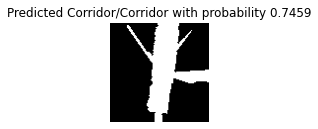

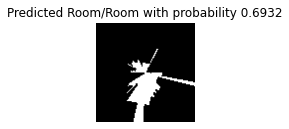

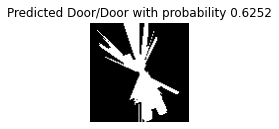

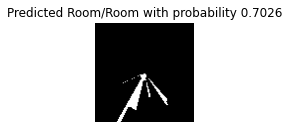

In [83]:
def imshow(inp, title=None):
    # de-normalize for visualization
    inp = inp.numpy().squeeze(0)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,'gray')
    if title is not None:
        plt.title(title)
    # pause a bit so that plots are updated
    plt.pause(0.001)


def predict(model, num_images=4):
    was_training = model.training
    model.eval()
    model.to(device)
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)     # batch x channel x width x height
            labels = labels.to(device)

            outputs = model(inputs)        # batch x classes
            prob = nn.functional.softmax(outputs,dim=1)
            prob, idx = prob.sort(1,True)  # batch x classes
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                if num_images == 1:
                    ax = plt.subplot(1, 1, 1)
                else:
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted {1}/{2} with probability {0:.4f}'.format(prob[j][0],
                    class_names[idx[j][0]].capitalize(), class_names[labels[j]].capitalize()))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


predict(net)

#Save Trained Model

In [ ]:
torch.save(net.state_dict(),root_dir+'LiNet-adam_lr1e4_decay1e6.pth')

with open(root_dir+'LiNet_categoryIndex.csv','w',newline='') as categoryIndexFile:
    categoryIndexWriter = csv.writer(categoryIndexFile, delimiter='\t')
    categoryIndexWriter.writerows(enumerate(class_names))
categoryIndexFile.close()